In [1]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import copy
import pandas as pd
import PIL
from PIL import Image, ImageChops, ImageOps
import time
import math

import albumentations
from albumentations import augmentations

import imgaug
from imgaug import augmenters as iaa

In [ ]:
'NIST' in 

In [2]:
def to_float(img, max_value=None):
    if max_value is None:
        try:
            max_value = MAX_VALUES_BY_DTYPE[img.dtype]
        except KeyError:
            raise RuntimeError(
                "Can't infer the maximum value for dtype {}. You need to specify the maximum value manually by "
                "passing the max_value argument".format(img.dtype)
            )
    return img.astype("float32") / max_value


def from_float(img, dtype, max_value=None):
    if max_value is None:
        try:
            max_value = MAX_VALUES_BY_DTYPE[dtype]
        except KeyError:
            raise RuntimeError(
                "Can't infer the maximum value for dtype {}. You need to specify the maximum value manually by "
                "passing the max_value argument".format(dtype)
            )
    return (img * max_value).astype(dtype)

MAX_VALUES_BY_DTYPE = {
    np.dtype("uint8"): 255,
    np.dtype("uint16"): 65535,
    np.dtype("uint32"): 4294967295,
    np.dtype("float32"): 1.0,
}


In [3]:
map_func = {}
map_func[0] = "Box Blur"
map_func[1] = "Gaussian Blur"
map_func[2] = "Median Blur"
map_func[3] = "JPEG Compression"
map_func[4] = "JPEG Double Compression"
map_func[5] = "JPEG Double Compression"
map_func[6] = "JPEG Double Compression"
map_func[7] = "JPEG Double Compression"
map_func[8] = "Nearest Resize"
map_func[9] = "Area Resize"
map_func[10] = "Cubic Resize"
map_func[11] = "Linear Resize"
map_func[12] = "Lanczos4 Resize"
map_func[13] = "WEBP Compression"
map_func[14] = "AutoContrast"
map_func[15] = "Impulse Noise"
map_func[16] = "Poisson Noise"
map_func[17] = "Gaussian Noise"
map_func[18] = "Erode Morph"
map_func[19] = "Dilate Morph"

In [4]:
#FUNCTION BLOCK

def boxBlur(img):
    #DONE
    k = [29, 11, 13, 15, 17, 19, 25, 27, 21, 23, 3, 7, 5, 9, 33, 31]
    randint = random.randint(0, len(k)-1) #0-15
    kernel = (k[randint], k[randint])
    image = cv2.blur(img, kernel)

    class_index = 1 + randint #1-16
    mp = {
      'id' : 0,
      'class_idx' : class_index,
      'name' : 'Box_Blur',
      'parameter' : "K = " + str(k[randint])
    }
    return (image, mp)


def gaussianBlur(img):
    #DONE
    k = [33, 31, 5, 7, 3, 9, 11, 13, 15, 17, 19, 29, 21, 23, 25, 27]
    randint = random.randint(0, len(k)-1) #0-15
    kernel = (k[randint], k[randint])
    image = cv2.GaussianBlur(img, kernel, 0)

    class_index = 17 + randint #17-32
    mp = {
      'id' : 1,
      'class_idx' : class_index,
      'name' : 'Gaussian_Blur',
      'parameter' : "K = " + str(k[randint])
    }
    return (image, mp)


def medianBlur(img):
    #DONE
    k = [21, 23, 25, 27, 29, 19, 15, 17, 11, 13, 9, 3, 7, 5, 33, 31]
    randint = random.randint(0, len(k)-1) #0-15
    kernel = k[randint]
    image = cv2.medianBlur(img, kernel) 

    class_index = 33 + randint #33-48
    mp = {
      'id' : 2,
      'class_idx' : class_index,
      'name' : 'Median_Blur',
      'parameter' : "K = " + str(k[randint])
    }
    return (image, mp)


#WAVELETBLUR


from albumentations.augmentations.functional import image_compression

def jpegCompression(image):
    #DONE
    k = [57, 53, 91, 95, 61, 65, 38, 100, 74, 70, 78, 48, 44, 40, 82, 87]
    randint = random.randint(0, len(k)-1) #0-15
    quality = k[randint]
    jpeg = image_compression(image, quality, '.jpg')
    
    class_index = 49 + randint #49-64
    mp = {
      'id' : 3,
      'class_idx' : class_index,
      'name' : 'JPEG_Compression',
      'parameter' : "Q = " + str(k[randint])
    }
    return (jpeg, mp)

def jpegDoubleCompression1(image):
    k1 = [95, 36, 95, 61, 70, 95, 53, 87, 78, 87, 95, 70, 78, 78, 87, 53]
    k2 = [40, 74, 57, 65, 100, 65, 74, 100, 57, 48, 100, 65, 40, 48, 65, 40]
    randint = random.randint(0, len(k1)-1) #0-15
    quality1, quality2 = k1[randint], k2[randint]

    decimg = image_compression(image, quality1, '.jpg')
    decimg1 = image_compression(decimg, quality2, '.jpg')
    
    class_index = 65 + randint #65-80
    mp = {
      'id' : 4,
      'class_idx' : class_index,
      'name' : 'JPEG_Double_Compression',
      'parameter' : "Q = " + str(k1[randint]) + ", " + str(k2[randint])
    } 
    return (decimg1, mp)

def jpegDoubleCompression2(image):
    k1 = [61, 87, 95, 70, 53, 61, 61, 44, 87, 95, 70, 87, 87, 53, 36, 44]
    k2 = [57, 57, 82, 91, 57, 40, 74, 48, 40, 91, 82, 82, 91, 65, 48, 74]
    randint = random.randint(0, len(k1)-1) #0-15
    quality1, quality2 = k1[randint], k2[randint]

    decimg = image_compression(image, quality1, '.jpg')
    decimg1 = image_compression(decimg, quality2, '.jpg')
    
    class_index = 81 + randint #81-96
    mp = {
      'id' : 5,
      'class_idx' : class_index,
      'name' : 'JPEG_Double_Compression',
      'parameter' : "Q = " + str(k1[randint]) + ", " + str(k2[randint])
    }
    return (decimg1, mp)

def jpegDoubleCompression3(image):
    k1 = [36, 61, 36, 53, 53, 36, 78, 78, 53, 70, 87, 61, 70, 95, 78, 44]
    k2 = [100, 91, 65, 48, 62, 57, 100, 74, 91, 57, 74, 48, 40, 48, 91, 40]
    randint = random.randint(0, len(k1)-1) #0-15
    quality1, quality2 = k1[randint], k2[randint]

    decimg = image_compression(image, quality1, '.jpg')
    decimg1 = image_compression(decimg, quality2, '.jpg')

    class_index = 97 + randint #97-112
    mp = {
      'id' : 6,
      'class_idx' : class_index,
      'name' : 'JPEG_Double_Compression',
      'parameter' : "Q = " + str(k1[randint]) + ", " + str(k2[randint])
    }
    return (decimg1, mp)

def jpegDoubleCompression4(image):
    k1 = [78, 36, 53, 44, 36, 36, 70, 61, 61, 44, 78, 44, 44, 95, 70, 44]
    k2 = [65, 40, 100, 100, 91, 82, 74, 100, 62, 62, 62, 57, 65, 74, 46, 91]
    randint = random.randint(0, len(k1)-1) #0-15
    quality1, quality2 = k1[randint], k2[randint]

    decimg = image_compression(image, quality1, '.jpg')
    decimg1 = image_compression(decimg, quality2, '.jpg')

    class_index = 113 + randint #113-128
    mp = {
      'id' : 7,
      'class_idx' : class_index,
      'name' : 'JPEG_Double_Compression',
      'parameter' : "Q = " + str(k1[randint]) + ", " + str(k2[randint])
    }
    return (decimg1, mp)

#def horizontalFlip(image):
#    aug = HorizontalFlip(p=1)
#   augmented = aug(image=image)
#   flipped_image = augmented['image']
#    return flipped_image

#def verticalFlip(image):
#    aug = VerticalFlip(p=1)
#    augmented = aug(image=image)
#    flipped_image = augmented['image']
#    return flipped_image

#def transpose(image):
#    aug = Transpose(p=1)
#    augmented = aug(image=image)
#    image_transpose = augmented['image']
#    return image_transpose

#def flip(image):
#    aug = Flip()
#    augmented = aug(image=image)
#    image_od = augmented['image']
#    return image_od

#def gaussNoise(image):
#    aug = GaussNoise(var_limit=(10.0, 50.0), always_apply=True, p=1)
#    augmented = aug(image=image)
#    image_od = augmented['image']
#    return image_od

#def additiveGaussianNoise(image):
#    aug = IAAAdditiveGaussianNoise(p = 1)
#    augmented = aug(image=image)
#    image_od = augmented['image']
#    return image_od


def nearestResize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.95, 0.20, 0.25, 0.31, 0.79, 0.73, 0.36, 0.41, 0.47, 0.52, 0.57, 0.84, 0.89, 0.15, 0.63, 0.68]
    randint = random.randint(0, len(k)-1) #0-15
    
    scale = k[randint]
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=cv2.INTER_NEAREST)
    
    class_index = 129 + randint #129-144
    mp = {
      'id' : 8,
      'class_idx' : class_index,
      'name' : 'Nearest_Resize',
      'parameter' : "S = " + str(k[randint])
    }
    return (upscaled, mp)

def areaResize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.95, 0.73, 0.79, 0.36, 0.31, 0.89, 0.84, 0.63, 0.68, 0.25, 0.20, 0.57, 0.52, 0.15, 0.41, 0.47]
    randint = random.randint(0, len(k)-1) #0-15
    
    scale = k[randint]
    image = to_float(image)
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=cv2.INTER_AREA)
    upscaled = from_float(np.clip(upscaled, 0, 1), dtype=np.dtype("uint8"))
    
    class_index = 145 + randint #145-160
    mp = {
      'id' : 9,
      'class_idx' : class_index,
      'name' : 'Area_Resize',
      'parameter' : "S = " + str(k[randint])
    } 
    return (upscaled, mp)

def cubicResize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.36, 0.68, 0.63, 0.84, 0.89, 0.31, 0.79, 0.73, 0.95, 0.47, 0.41, 0.15, 0.57, 0.52, 0.25, 0.20]
    randint = random.randint(0, len(k)-1) #0-15

    scale = k[randint]
    image = to_float(image)
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=cv2.INTER_CUBIC)
    upscaled = from_float(np.clip(upscaled, 0, 1), dtype=np.dtype("uint8"))
    
    class_index = 161 + randint #161-176
    mp = {
      'id' : 10,
      'class_idx' : class_index,
      'name' : 'Cubic_Resize',
      'parameter' : "S = " + str(k[randint])
    } 
    return (upscaled, mp)

def linearResize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.41, 0.47, 0.95, 0.73, 0.79, 0.36, 0.31, 0.84, 0.63, 0.68, 0.25, 0.20, 0.57, 0.52, 0.89, 0.15]
    randint = random.randint(0, len(k)-1) #0-15

    scale = k[randint]
    image = to_float(image)
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=cv2.INTER_LINEAR)
    upscaled = from_float(np.clip(upscaled, 0, 1), dtype=np.dtype("uint8"))

    class_index = 177 + randint #177-192
    mp = {
      'id' : 11,
      'class_idx' : class_index,
      'name' : 'Linear_Resize',
      'parameter' : "S = " + str(k[randint])
    }
    return (upscaled, mp)

def lanczos4Resize(image):
    #DONE
    h, w = image.shape[:2]
    k = [0.36, 0.31, 0.79, 0.73, 0.47, 0.41, 0.89, 0.84, 0.15, 0.52, 0.57, 0.25, 0.20, 0.68, 0.63, 0.95]
    randint = random.randint(0, len(k)-1) #0-15

    scale = k[randint]
    image = to_float(image)
    downscaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LANCZOS4)
    upscaled = cv2.resize(downscaled, (h, w), interpolation=cv2.INTER_LANCZOS4)
    upscaled = from_float(np.clip(upscaled, 0, 1), dtype=np.dtype("uint8"))

    class_index = 193 + randint #193-208
    mp = {
      'id' : 12,
      'class_idx' : class_index,
      'name' : 'Lanczos4_Resize',
      'parameter' : "S = " + str(k[randint])
    }
    return (upscaled, mp)


def webpComp(image):
    #DONE
    k = [53, 87, 82, 100, 65, 61, 95, 91, 36, 57, 78, 70, 74, 40, 44, 48]
    randint = random.randint(0, len(k)-1) #0-15

    quality = k[randint]
    webp = image_compression(image, quality, '.webp')

    class_index = 209 + randint #209-224
    mp = {
      'id' : 13,
      'class_idx' : class_index,
      'name' : 'WEPB_Compression',
      'parameter' : "Q = " + str(k[randint])
    } 
    return (webp, mp)


def autoContrast(image):
    k = [2, 3, 0, 1, 6, 7, 4, 5]
    randint = random.randint(0, len(k)-1) #0-7

    cutoff = k[randint]
    augmented = iaa.pillike.autocontrast(image, cutoff=cutoff)

    class_index = 225 + randint #225-232
    mp = {
      'id' : 14,
      'class_idx' : class_index,
      'name' : 'AutoContrast',
      'parameter' : "C = " + str(cutoff)
    } 
    return (augmented, mp)

# def autoContrast(image):
#     ignore = None
#     k = [2, 3, 0, 1, 6, 7, 4, 5]
#     randint = random.randrange(0, len(k))
#     cutoff = k[randint]
    
#     class_index = 225 + randint
#     mp = {}
#     mp['id'] = 14
#     mp['class_idx'] = class_index
#     mp['name'] = "AutoContrast"
#     mp["parameter"] = "C = " + str(cutoff) 

#     return (np.array(
#       PIL.ImageOps.autocontrast(
#         PIL.Image.fromarray(image),
#         cutoff=cutoff, ignore=ignore
#       )
#     ), mp)


def impulseNoise(image):
    k = [13, 11, 17, 15, 9, 3, 5, 7, 28, 26, 24, 22, 20, 30, 32, 35]
    randint = random.randint(0, len(k)-1) #0-15
    prob = k[randint] / 100.0
    
    aug = iaa.SaltAndPepper(prob)
    augmented = aug(image=image)
    
    class_index = 233 + randint #233-248
    mp = {
      'id' : 15,
      'class_idx' : class_index,
      'name' : 'Impulse_Noise',
      'parameter' : "P = " + str(k[randint])
    }
    return (augmented, mp)

def poissonNoise(image):
    k = [24, 26, 20, 22, 28, 3, 7, 5, 9, 35, 32, 30, 15, 17, 11, 13]
    randint = random.randint(0, len(k)-1) #0-15

    lam = 1.0 * k[randint]
    aug = iaa.AdditivePoissonNoise(lam=lam)
    augmented = aug(image=image)

    class_index = 249 + randint #249-264
    mp = {
      'id' : 16,
      'class_idx' : class_index,
      'name' : 'Poisson_Noise',
      'parameter' : "L = " + str(k[randint])
    }    
    return (augmented, mp)

def gaussianNoise(image):
    k = [3, 7, 5, 9, 30, 32, 35, 22, 20, 26, 24, 28, 17, 15, 13, 11]
    randint = random.randint(0, len(k)-1) #0-15

    scale = k[randint]
    aug = iaa.AdditiveGaussianNoise(scale=scale)
    augmented = aug(image=image)
    
    class_index = 265 + randint #265-280
    mp = {
      'id' : 17,
      'class_idx' : class_index,
      'name' : 'Gaussian_Noise',
      'parameter' : "S = " + str(k[randint])
    }
    return (augmented, mp)


def erodeMorph(image):
    k = [16, 31, 34, 21, 23, 25, 27, 29, 8, 2, 6, 4, 19, 14, 10, 12]
    randint = random.randint(0, len(k)-1) #0-15

    kernel = np.ones((k[randint], k[randint]), np.uint8)
    erosion = cv2.erode(image, kernel, iterations = 1)
    
    class_index = 281 + randint #281-296
    mp = {
      'id' : 18,
      'class_idx' : class_index,
      'name' : 'Erode_Morph',
      'parameter' : "S = " + str(k[randint])
    }
    return (erosion, mp)

def dilateMorph(image):
    k = [21, 23, 25, 27, 19, 14, 16, 10, 12, 29, 31, 34, 8, 2, 4, 6]
    randint = random.randint(0, len(k)-1) #0-15

    kernel = np.ones((k[randint], k[randint]), np.uint8)
    dilation = cv2.dilate(image, kernel, iterations=1)
    
    class_index = 297 + randint #297-312
    mp = {
      'id' : 19,
      'class_idx' : class_index,
      'name' : 'Dilate_Morph',
      'parameter' : "S = " + str(k[randint])
    } 
    return (dilation, mp)


function:**In pass an image -> get augmented images**

In [5]:
def augment(image):
  seed = random.randint(0, 19) # 0 - 19 -> 20 augs
  
  if seed == 0:
    return boxBlur(image)
  elif seed == 1:
    return gaussianBlur(image)
  elif seed == 2:
    return medianBlur(image)
  elif seed == 3:
    return jpegCompression(image)
  elif seed == 4:
    return jpegDoubleCompression1(image)
  elif seed == 5:
    return jpegDoubleCompression2(image)
  elif seed == 6:
    return jpegDoubleCompression3(image)
  elif seed == 7:
    return jpegDoubleCompression4(image)
  elif seed == 8:
    return nearestResize(image)
  elif seed == 9:
    return areaResize(image)
  elif seed == 10:
    return cubicResize(image)
  elif seed == 11:
    return linearResize(image)
  elif seed == 12:
    return lanczos4Resize(image)
  elif seed == 13:
    return webpComp(image)
  elif seed == 14:
    return autoContrast(image)
  elif seed == 15:
    return impulseNoise(image)
  elif seed == 16:
    return poissonNoise(image)
  elif seed == 17:
    return gaussianNoise(image)
  elif seed == 18:
    return erodeMorph(image)
  elif seed == 19:
    return dilateMorph(image)

In [6]:
def solve(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, (1536, 1536), cv2.INTER_AREA)
    
    patch_list = []
    for i in range(0, image.shape[0], 256):
      for j in range(0, image.shape[1], 256):
        x = i + 256
        y = j + 256
        if x > image.shape[0] or y > image.shape[1]:
          break
        patch = image[i : x, j : y, :]

        augs = augment(patch)
        patch_list.append(augs) #augmented -> return type: (image, string) tuple

    return patch_list

In [7]:
im_path = 'Image_Manipulation_Dataset/FODB/original_images/part01/D01_Motorola_E3_1/orig/D01_img_orig_0001.jpg'
ret = solve(im_path)

error: OpenCV(4.5.1) /tmp/pip-req-build-jhawztrk/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


{'id': 8, 'class_idx': 130, 'name': 'Nearest_Resize', 'parameter': 'S = 0.2'} (256, 256, 3)


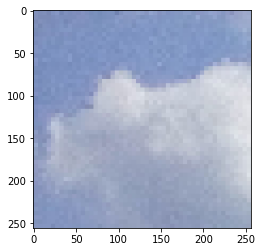

{'id': 11, 'class_idx': 189, 'name': 'Linear_Resize', 'parameter': 'S = 0.57'} (256, 256, 3)


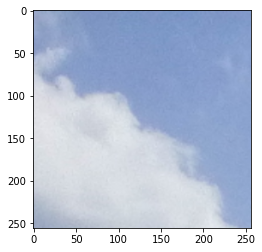

{'id': 17, 'class_idx': 279, 'name': 'Gaussian_Noise', 'parameter': 'S = 13'} (256, 256, 3)


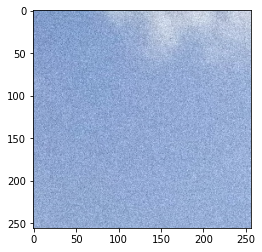

{'id': 8, 'class_idx': 144, 'name': 'Nearest_Resize', 'parameter': 'S = 0.68'} (256, 256, 3)


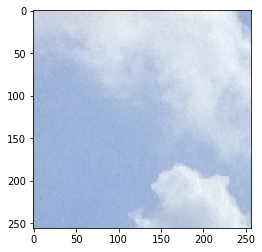

{'id': 16, 'class_idx': 263, 'name': 'Poisson_Noise', 'parameter': 'L = 11'} (256, 256, 3)


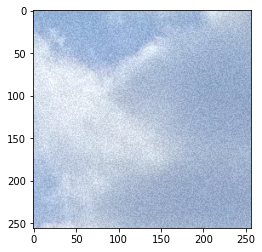

{'id': 3, 'class_idx': 63, 'name': 'JPEG_Compression', 'parameter': 'Q = 82'} (256, 256, 3)


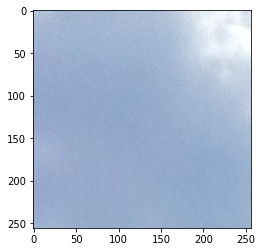

{'id': 4, 'class_idx': 69, 'name': 'JPEG_Double_Compression', 'parameter': 'Q = 70, 100'} (256, 256, 3)


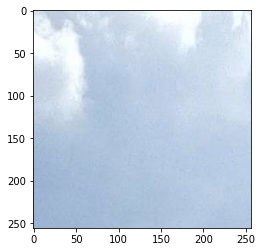

{'id': 13, 'class_idx': 219, 'name': 'WEPB_Compression', 'parameter': 'Q = 78'} (256, 256, 3)


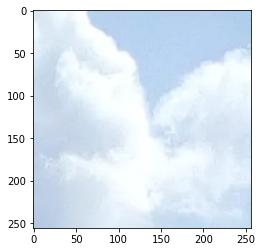

{'id': 9, 'class_idx': 159, 'name': 'Area_Resize', 'parameter': 'S = 0.41'} (256, 256, 3)


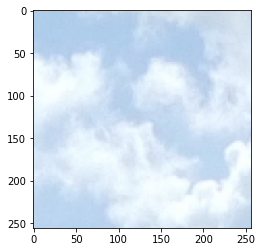

{'id': 0, 'class_idx': 9, 'name': 'Box_Blur', 'parameter': 'K = 21'} (256, 256, 3)


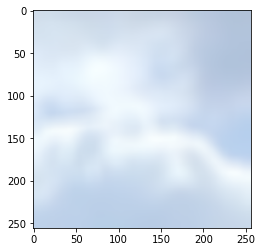

In [9]:
for (image, details) in ret[:10]:
    print(details, image.shape)
    plt.figure()
    plt.imshow(image)
    plt.show()

In [10]:
import glob

image_list = glob.glob('Image_Manipulation_Dataset/FODB/original_images/*/*/orig/*.jpg', recursive=True)

In [11]:
OUTDIR = 'Image_Manipulation_Dataset/FODB/extracted_images'
data = []

for path in tqdm(image_list):
    
    iname = path.split('/')[-1][:-4].split('_')
    
    ret = solve(path)
    
    idx = 1001
    for (image, details) in ret:
        startx = random.randint(0, 127)
        starty = random.randint(0, 127)
        patch = image[startx:startx+128, starty:starty+128, :]
        
        fname = iname[0]+ "_" + iname[-1] + "_" + details['name'] + "_" + str(idx) + ".jpg"
        details['image_name'] = fname
        data.append(details)

        patch = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(OUTDIR, fname), patch)

        idx += 1

df = pd.DataFrame(data)
df.to_csv('pretrain_images.csv', index=False)

100%|██████████| 3851/3851 [39:52<00:00,  1.61it/s]


In [9]:
df = pd.read_csv('pretrain_images.csv')
df.class_idx -= 1
df.class_idx.nunique()

312

In [11]:
df.to_csv('pretrain_images.csv', index=False)

# COVERAGE & NIST Sampling

In [14]:
geo_aug = albumentations.Compose(
    [
        albumentations.OneOf([
            augmentations.transforms.HorizontalFlip(),
            augmentations.transforms.VerticalFlip(),
            albumentations.RandomRotate90(),
        ], p=0.9),      
        albumentations.ShiftScaleRotate(shift_limit=0.04, scale_limit=0.08, rotate_limit=65, p=0.6),
        albumentations.OneOf([
            augmentations.geometric.transforms.ElasticTransform(),
            # augmentations.transforms.GridDistortion(),
            albumentations.OpticalDistortion(),
        ], p=0.3),                 
        augmentations.geometric.transforms.Perspective(p=0.5),
        # augmentations.crops.transforms.RandomCrop(height=50, width=50, p=0.6)
        # albumentations.OneOf([
        #     augmentations.transforms.CoarseDropout(max_height=50, max_width=50),
        #     augmentations.transforms.Cutout(max_h_size=50, max_w_size=50),
        # ], p=0.5),
        # augmentations.transforms.RandomGridShuffle(p=0.4),
    ]
)

In [15]:
def sampling(image, mask, count, label):
    samples = []
    i = 0
    while(i < count):
        sample_image = copy.deepcopy(image)
        sample_mask = copy.deepcopy(mask)

        # aug_image, details = augment(sample_image)

        data = geo_aug(image=sample_image, mask=sample_mask)
        aug_image = data["image"]
        aug_mask = data["mask"]

        if(cv2.countNonZero(aug_mask) < 100 and label==1):
            continue
            
        i += 1
        samples.append((aug_image, aug_mask)) #augmented -> return type: (image, string) tuple
    return samples

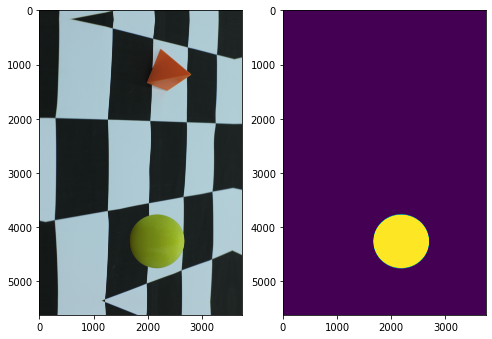

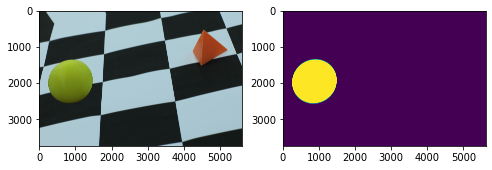

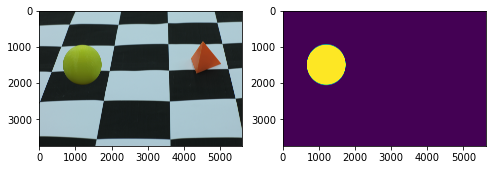

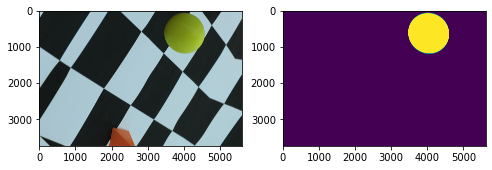

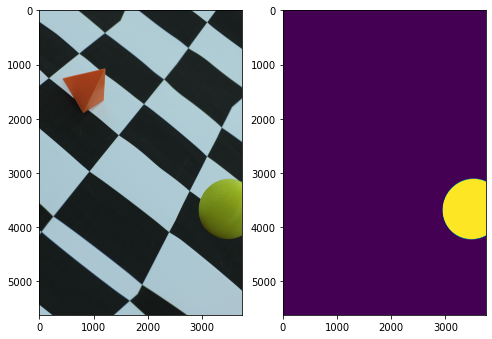

In [4]:
im_path = '/media/crimson/SSD Disk/Datasets/NIST16v2/images/NC2016_0128.png'
mask_path = '/media/crimson/SSD Disk/Datasets/NIST16v2/masks/NC2016_0128.png'

image = cv2.imread(im_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# crop = augmentations.crops.transforms.Crop(x_min=50, y_min=50, x_max=400, y_max=400)
# data = crop(image=image, mask=mask_image)
# plt.figure(figsize=(8,8))
# plt.subplot(1,2,1)
# plt.imshow(data['image'])
# plt.subplot(1,2,2)
# plt.imshow(data['mask'])
# plt.show()

ret = sampling(image, mask_image, 5, 1)
for sample in ret:
    image = sample[0]
    mask = sample[1]
    # details = sample[2]

    # print(details)
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

    # fname = im_path.split('/')[-1][:-4]
    # outname = fname+"_"+details['name'].split(' ')[0]+"_"+str(i)+".jpg"
    # maskname = outname[:-4]+"_gt.jpg"
    # elaname = outname[:-4]+"_ela.jpg"
    # label = 1
    

In [5]:
# full_df = pd.read_csv('combo_all_FULL.csv')
# coverage_full = full_df[full_df['root_dir'].str.contains('COVERAGE')]
nist_full = pd.read_csv('/media/crimson/Dataset/image_manipulation/dataset_csv/nist16v2.csv')
# imd_full = full_df[full_df['root_dir'].str.contains('IMD')]
# casia_full = full_df[full_df['root_dir'].str.contains('CASIA')]
# cmfd_full = full_df[full_df['root_dir'].str.contains('CMFD')]

In [6]:
nist_full.label.value_counts()

1    560
Name: label, dtype: int64

In [16]:
root_folder = '/media/crimson/SSD Disk/Datasets'
out_dir = 'NIST16v2_extend'

data = []
for row in tqdm(nist_full.values):
    image_patch, mask_patch, label, fold, ela, root_dir = row

    image_path = os.path.join(root_folder, root_dir, image_patch)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # plt.figure()
    # plt.imshow(image)
    # plt.show()
    image = cv2.resize(image, (960,960), cv2.INTER_CUBIC)
    
    if label == 0:
        mask_image = np.zeros((image.shape[0], image.shape[1])).astype('uint8')
    else:
        mask_path = os.path.join(root_folder, root_dir, mask_patch)
        mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_image = cv2.resize(mask_image, (960,960), cv2.INTER_CUBIC)

    if label == 1:
        samples = sampling(image, mask_image, 7, label)
    else:
        samples = sampling(image, mask_image, 2, label)
    
    filename = image_patch.split('/')[-1][:-4]
    out_folder = os.path.join(root_folder, out_dir, filename)
    os.makedirs(out_folder, exist_ok=True)
    # print(out_folder)
    for i, sample in enumerate(samples):
        image = sample[0]
        mask = sample[1]
        # details = sample[2]

        # imname = details['name'].split(' ')[0]+"_"+str(i)+".jpg"
        imname = str(i).zfill(3)+".jpg"
        maskname = imname[:-4]+"_gt.jpg"
        elaname = imname[:-4]+"_ela.jpg"
        # print(imname)
        # print(maskname)
        # print(elaname)
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(out_folder, imname), image)
        if label == 1:
            cv2.imwrite(os.path.join(out_folder, maskname), mask)
            mask_key = filename+"/"+maskname
        else:
            mask_key = ''

        data.append({
            "image_patch" : filename+"/"+imname,
            "mask_patch" : mask_key,
            "label" : label,
            "fold" : -1,
            "ela" : filename+"/"+elaname,
            "root_dir" : out_dir
        })

100%|██████████| 560/560 [27:09<00:00,  2.91s/it]


In [17]:
extend_df = pd.DataFrame(data)
# extend_df.head()
print(extend_df.label.value_counts())

1    3920
Name: label, dtype: int64


In [18]:
extend_df.to_csv('nist_extendv2.csv', index=False)

In [27]:
nist_extend_df = pd.read_csv('nist_extend.csv')
# nist_extend_df_real_sample = nist_extend_df[nist_extend_df['label'] == 0].sample(n=2000, random_state=123)
# nist_extend_df_fake_sample = nist_extend_df[nist_extend_df['label'] == 1].sample(n=2000, random_state=123)
# sample_nist = pd.concat([nist_extend_df_real_sample, nist_extend_df_fake_sample])
nist_extend_df.label.value_counts()

1    1940
0    1748
Name: label, dtype: int64

In [28]:
coverage_extend_df = pd.read_csv('coverage_extend.csv')
# coverage_extend_df_real_sample = coverage_extend_df[coverage_extend_df['label'] == 0].sample(n=2000, random_state=123)
# coverage_extend_df_fake_sample = coverage_extend_df[coverage_extend_df['label'] == 1].sample(n=2000, random_state=123)
# sample_coverage = pd.concat([coverage_extend_df_real_sample, coverage_extend_df_fake_sample])
coverage_extend_df.label.value_counts()

0    1500
1    1500
Name: label, dtype: int64

In [76]:
sample_nist.to_csv('nist_extend_sample.csv', index=False)

In [4]:
from sklearn import model_selection

nist_extend = pd.read_csv('nist_extend.csv')
nist_extend['fold'] = -1
y = nist_extend.label.values
kf = model_selection.StratifiedKFold(n_splits=10)

for f, (t_, v_) in enumerate(kf.split(X=nist_extend, y=y)):
    nist_extend.loc[v_, 'fold'] = f

In [5]:
nist_extend.to_csv('nist_extend.csv', index=False)

In [54]:
## Check path validity

sampled_df = pd.read_csv('nist_extend.csv')
root_folder = 'Image_Manipulation_Dataset'
for index, row in tqdm(sampled_df.iterrows()):
    image_patch, mask_patch, label, fold, ela, root_dir = row
    impath = os.path.join(root_folder, root_dir, image_patch)
    ela_path = os.path.join(root_folder, root_dir, ela)
    if not os.path.exists(impath):
        print(impath)
    # if not os.path.exists(ela_path):
    #     print(ela_path)
    if label==1:
        mask_path = os.path.join(root_folder, root_dir, mask_patch)
        if not os.path.exists(mask_path):
            print(mask_path)
    # # name = row['image_patch']
    # mask_name = row['mask_patch']
    # ela_name = row['ela']
    # # sampled_df.loc[index, 'image_patch'] = name.split('_', 1)[0]+"/"+name
    # sampled_df.loc[index, 'mask_patch'] = mask_name.split('_', 1)[0]+"/"+mask_name
    # sampled_df.loc[index, 'ela'] = ela_name.split('_', 1)[0]+"/"+ela_name

7572it [00:00, 10749.16it/s]


In [60]:
df = pd.read_csv('nist_extend.csv')
for index, row in tqdm(df.iterrows()):
    image_patch, mask_patch, label, fold, ela, root_dir = row
    # impath = os.path.join(root_folder, root_dir, image_patch)
    # ela_path = os.path.join(root_folder, root_dir, ela)
    # if not os.path.exists(impath):
    #     print(impath)
    # if not os.path.exists(ela_path):
    #     print(ela_path)
    # if label==1:
    #     mask_path = os.path.join(root_folder, root_dir, mask_patch)
    #     if not os.path.exists(mask_path):
    #         print(mask_path)
    # # name = row['image_patch']
    # mask_name = row['mask_patch']
    # ela_name = row['ela']
    # # sampled_df.loc[index, 'image_patch'] = name.split('_', 1)[0]+"/"+name
    # sampled_df.loc[index, 'mask_patch'] = mask_name.split('_', 1)[0]+"/"+mask_name
    # sampled_df.loc[index, 'ela'] = ela_name.split('_', 1)[0]+"/"+ela_name
    if label == 0:
        df.loc[index, 'mask_patch'] = ''

4950it [00:01, 3568.15it/s]


In [61]:
df.to_csv('nist_extend.csv', index=False)

In [62]:
combo_all_df = pd.read_csv('combo_all_FULL.csv').sample(frac=1.0, random_state=123)
nist_extend = pd.read_csv('nist_extend.csv').sample(frac=1.0, random_state=123)
coverage_extend = pd.read_csv('coverage_extend.csv').sample(frac=1.0, random_state=123)

df = pd.concat([combo_all_df, nist_extend, coverage_extend])

In [63]:
df.groupby('root_dir').label.value_counts()

root_dir                  label
CASIA_2.0                 0        7491
                          1        5102
COCO_CMFD/cmfd_full       0        3547
                          1        3547
COVERAGE/coverage_extend  0        2700
                          1        2700
COVERAGE/coverage_full    0         100
                          1         100
IMD2020/imd_data          0        1206
                          1        1153
NIST16/nist16_full        0         874
                          1         388
NIST16/nist_extend        0        2622
                          1        2328
Name: label, dtype: int64